In [6]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.family": "Times New Roman"})
colors = ["#072D41", "#60B3C8", "#ECA918", "#359735"]

from plotnine import (
    ggplot, aes, geom_line, scale_colour_manual,
    geom_abline, element_blank,
    facet_wrap, theme_bw, theme,
    coord_fixed, element_text
    )

In [62]:
task_names = ["fraziergaussian", "sirsde", "cancer"]
pretty_task_names = {"fraziergaussian": "Gaussian", "sirsde": "SIR", "cancer": "Cancer"}
pretty_method_names = {"NPE": "NPE", "Robust NPE": "RNPE"}

results = {t: [] for t in task_names}
frazier_y = []
frazier_theta_true = []

for task in task_names:
    results_dir = f"../results/{task}/"
    for f_name in sorted(os.listdir(results_dir)):
        if ".pickle" in f_name:
            with open(results_dir + f_name, "rb") as f:
                res = pickle.load(f)
                results[task].append(res["metrics"])

            if task == "fraziergaussian":
                frazier_y.append(res["data"]["y"]) # To add true posterior
                frazier_theta_true.append(res["data"]["theta_true"])

frazier_y = np.row_stack(frazier_y)    
frazier_theta_true = np.row_stack(frazier_theta_true) 

In [65]:
df_list = []

for task in task_names:
    for method in pretty_method_names.keys():
        task_em_res = [res[method] for res in results[task]]
        metrics = {k: [res[k] for res in task_em_res] for k in ["log_prob_theta*", "hpd"]}
        metrics["Task"] = pretty_task_names[task]
        metrics["Method"] = pretty_method_names[method]
        df_list.append(pd.DataFrame(metrics))

df = pd.concat(df_list)
df["Method"] = pd.Categorical(df["Method"], categories=["RNPE", "NPE"])
df = df.reset_index(drop=True)


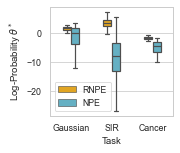

In [79]:
# palette = {"RNPE": "#b8e3c1", "NPE": "#9a83a6"}
# palette = {"RNPE": "#ffa600", "NPE": "#7a5195"}
# palette = {"RNPE": "#81b29a", "NPE": "#9a83a6"}

palette = {"RNPE": colors[2], "NPE": colors[1]}

fig = plt.figure()
fig.set_size_inches(5.5*(2/5), 2, forward=True)

p = sns.boxplot(
    x = "Task",
    y = "log_prob_theta*",
    hue = "Method",
    showfliers=False,
    width=0.4,
    data=df,
    palette=palette,
    saturation=0.9)

plt.ylabel(r"Log-Probability $\theta^*$")
handles, labels = p.get_legend_handles_labels() # Remove legend title
p.legend(handles=handles, labels=labels, loc = "lower left")

plt.savefig("../results/plots/log_prob_theta_true.png", bbox_inches="tight", dpi=300)

## Coverage plot

In [80]:
import numpy as np

confidence_level = np.linspace(0, 1, 1001)

cov_df_list = []
for task in pretty_task_names.values():
    for method in pretty_method_names.values():
        coverage = []
        for level in confidence_level:
            hpd_subset = df["hpd"][(df["Task"] == task) & (df["Method"] == method)]
            coverage.append(sum(hpd_subset/100 <= level)/len(hpd_subset))
        
        cov_df_list.append(
            pd.DataFrame({
                "Confidence Level": confidence_level,
                "Empirical Coverage": coverage,
                "Task": task,
                "Method": method
            })
        )
cov_df = pd.concat(cov_df_list)
cov_df = cov_df.reset_index(drop=True)
cov_df = cov_df.drop_duplicates()
cov_df["Method"] = pd.Categorical(cov_df["Method"], categories=["RNPE", "NPE"])


/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.3 x 3 in image.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../results/plots/coverage.png
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packa

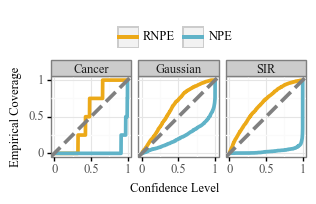

<ggplot: (8731367963266)>

In [81]:
from plotnine import scale_x_continuous, scale_y_continuous, element_rect, element_blank
txt = element_text(family="Times New Roman", size=9)
cov_p = (
    ggplot(aes(x="Confidence Level", y="Empirical Coverage", colour="Method"), data=cov_df) +
    facet_wrap("~Task", nrow=1) +
    geom_line(size=1.5) +
    scale_colour_manual(values=palette) +
    geom_abline(slope=1, intercept=0, size=1.5, linetype="dashed", color="grey") +
    theme_bw() +
    coord_fixed() +
    scale_x_continuous(breaks=[0, 0.5, 1]) +
    scale_y_continuous(breaks=[0, 0.5, 1]) +
    theme(
        legend_title=element_blank(),
        legend_position = "top", # (0.22, 0.7),
        legend_box_spacing=-.35,
        strip_text_x = element_text(
            margin={'t': 15, 'b': 10}),
        text=txt, title=txt, axis_title=txt, strip_text=txt,
        figure_size=(5.5*(3/5), 3),
        legend_background=element_blank()
        )
)
cov_p.save("../results/plots/coverage.png", dpi=300)
cov_p


### Plot examples

In [18]:
from rnpe.utils import pairplot

def plot_denoised(task, seed=0, n=10000, **kwargs):
    f_name = f"../results/{task}/{seed}.pickle"
    with open(f_name, "rb") as f:
        res = pickle.load(f)

    denoised = {
        "Simulations": np.random.permutation(res["data"]["x"])[:n],
        "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n]
        }

    pairplot(
        denoised,
        res["data"]["y"],
        col_names=res["names"]["x"],
        true_name="y",
        colors=[colors[i] for i in range(len(colors)) if i!=1],
        **kwargs
        )
    plt.show()

def plot_posteriors(task, seed=0, n=10000, **kwargs):
    f_name = f"../results/{task}/{seed}.pickle"

    with open(f_name, "rb") as f:
        res = pickle.load(f)
    
    posteriors = {
        "Prior": res["data"]["theta"][:n],
        "NPE": res["posterior_samples"]["NPE"][:n],
        "RNPE": res["posterior_samples"]["Robust NPE"][:n],
    }

    pairplot(
        posteriors,
        res["data"]["theta_true"],
        col_names=res["names"]["theta"],
        true_name=r"$\theta^*$",
        colors=colors,
        **kwargs)
    plt.show()

    

In [390]:

def plot_example(task, seed = 0, n = 10000):
    f_name = f"../results/{task}/{seed}.pickle"
    with open(f_name, "rb") as f:
        res = pickle.load(f)

    

    # Denoise plot
    n = 10000
    denoised = {
        "Simulations": np.random.permutation(res["data"]["x"])[:n],
        "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n]
        }

    pairplot(
        denoised,
        res["data"]["y"],
        col_names=res["names"]["x"],
        true_name="y",
        true_point_size=20,
        colors=[colors[i] for i in range(len(colors)) if i!=1] 
        )
    plt.show()

    # plot posteriors
    






In [402]:
from scipy.stats.distributions import poisson

poisson.cdf(1000, 1200)

1.553146982114243e-09

fraziergaussian


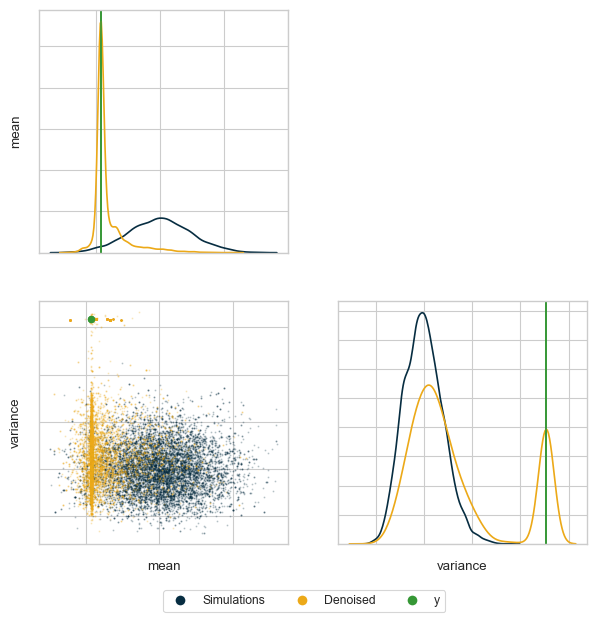

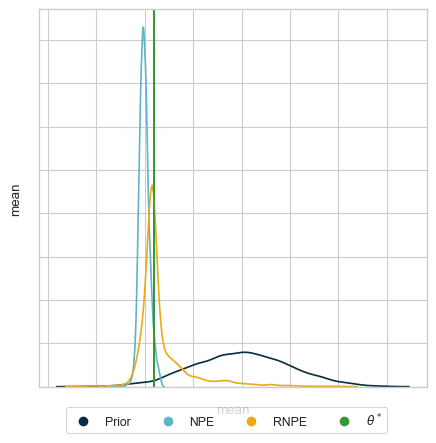

sirsde


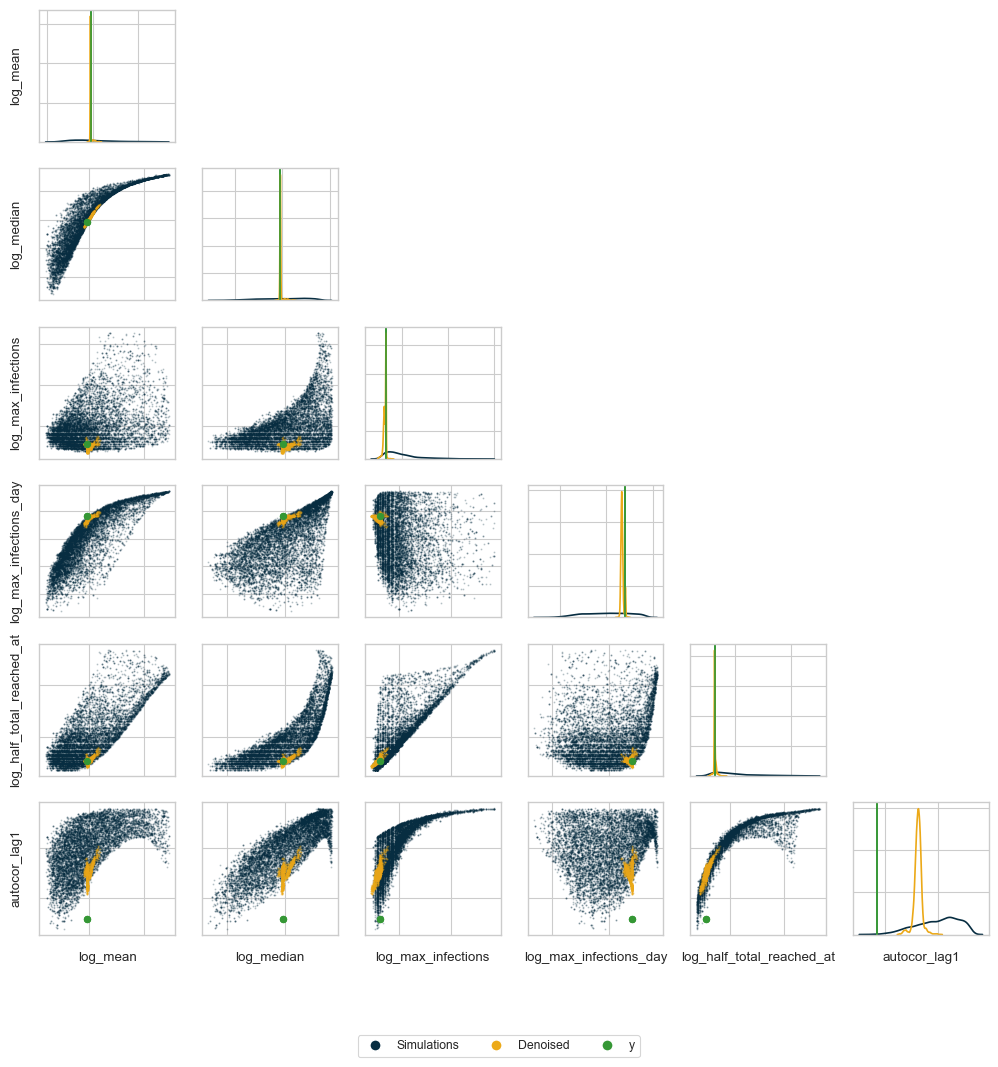

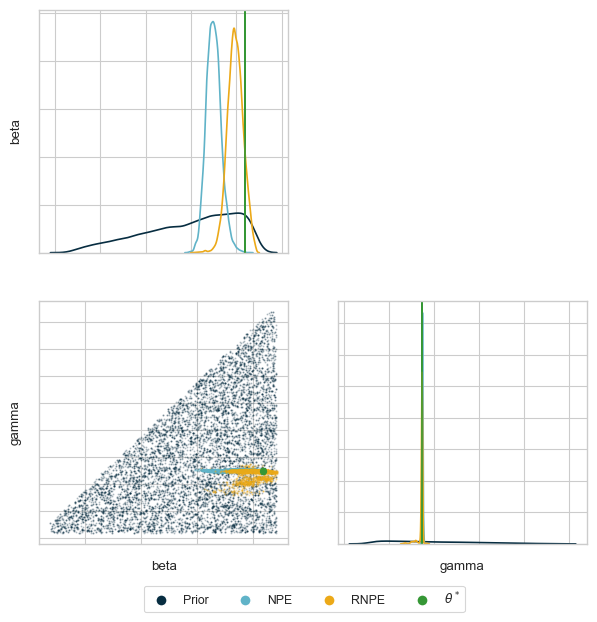

cancer


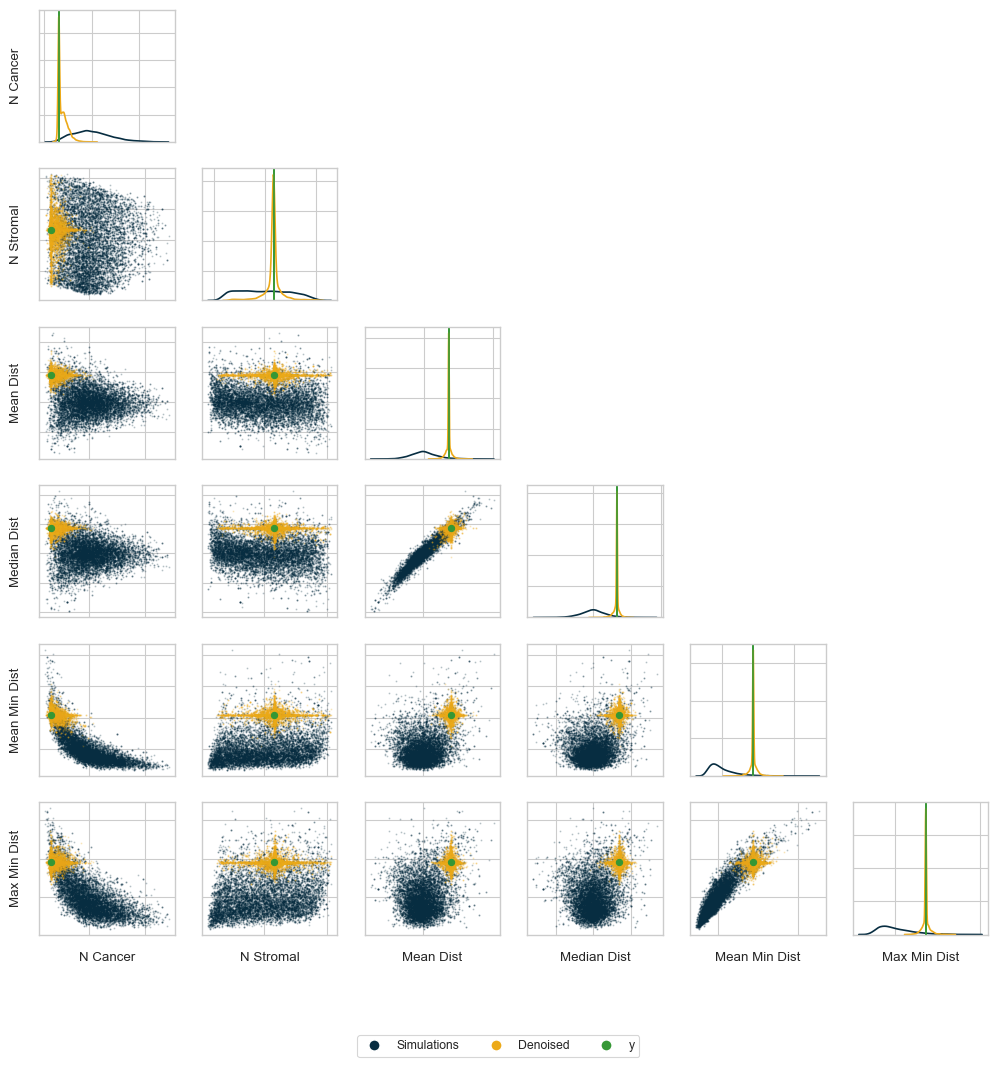

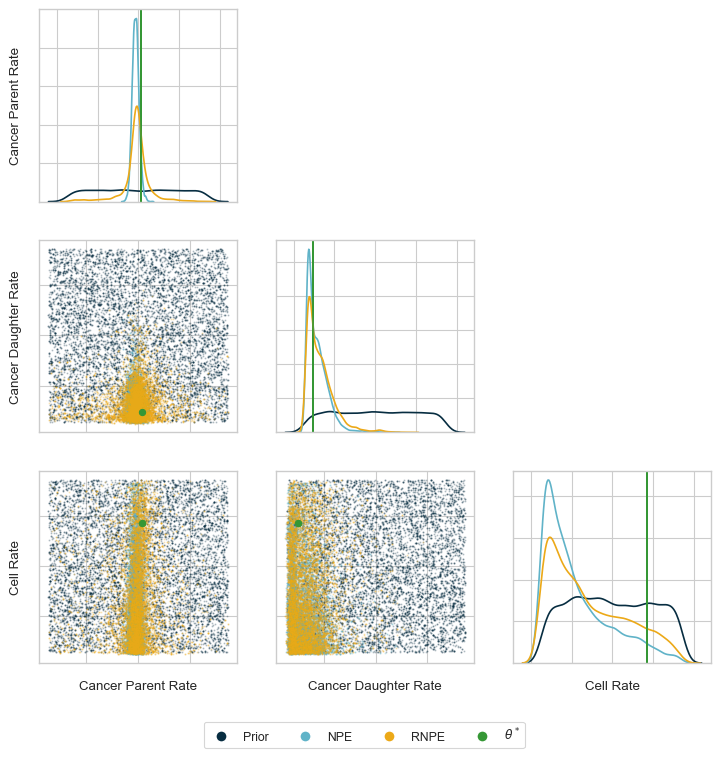

In [22]:
for task in ["fraziergaussian", "sirsde", "cancer"]:
    print(task)
    plot_denoised(task, seed=3)
    plot_posteriors(task, seed=3)

In [38]:
f_name = f"../results/cancer/2.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)
res["metrics"]

{'Robust NPE': {'log_prob_theta*': -1.6505556106567383,
  'hpd': 42.53000020980835,
  'point_estimate_residuals': array([-0.22382745, -0.6215643 ,  0.8354425 ], dtype=float32)},
 'NPE': {'log_prob_theta*': -3.6701250076293945,
  'hpd': 97.46999740600586,
  'point_estimate_residuals': array([-0.22327808, -0.88046145,  0.44950604], dtype=float32)}}

In [39]:
res["mcmc_samples"]["misspecified"].mean(axis=0)

array([0.64792, 0.49912, 0.44709, 0.40825])

### Cancer example

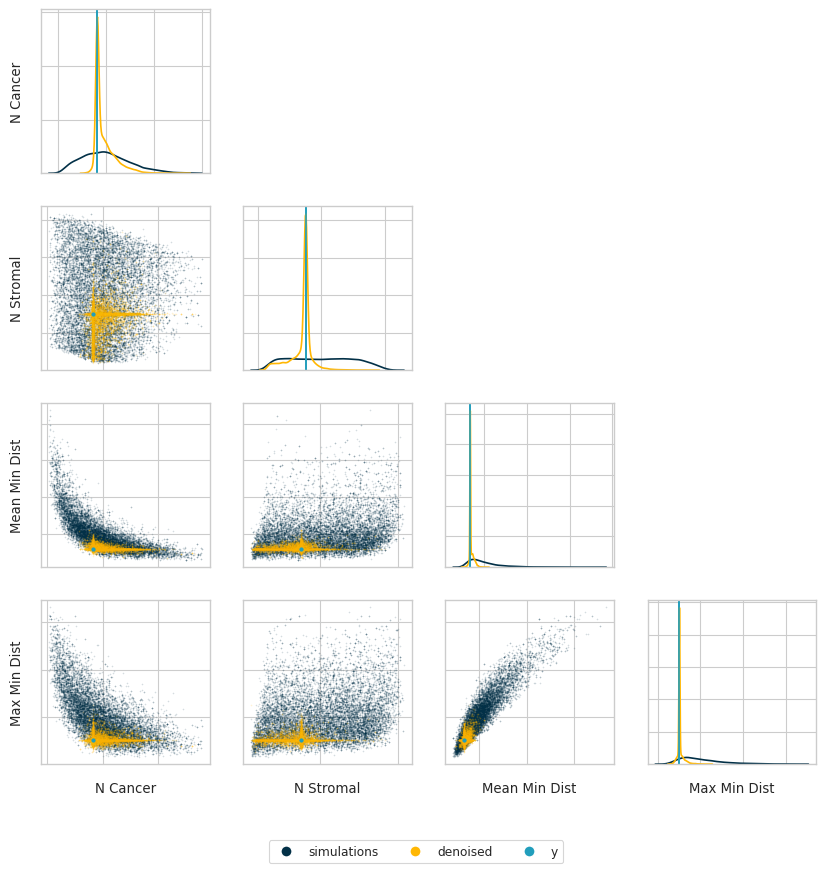

In [262]:
seed = 0
f_name = f"../results/cancer/{seed}.pickle"

with open(f_name, "rb") as f:
    res = pickle.load(f)
    
# Denoise plot
n = 15000
denoised = {
    "simulations": np.random.permutation(res["data"]["x"])[:n],
    "denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n]
    }

pairplot(
    denoised,
    res["data"]["y"],
    col_names=res["names"]["x"],
    true_name="y",
    colors=[colors[i] for i in [2,3,1]])



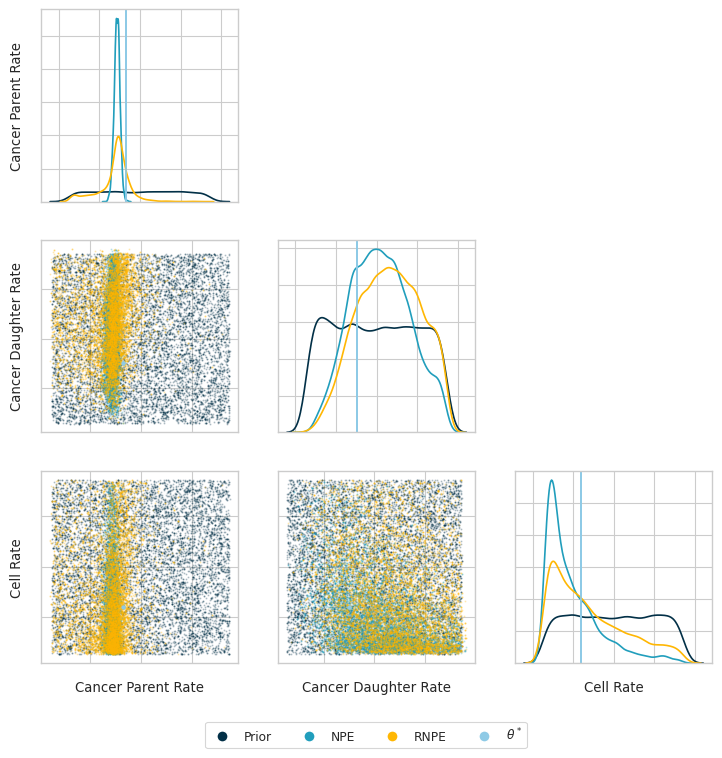